# Hydropower Atlas vs Utility Data – Capacity factor comparison

User needs:
1. to put the utility hydropower data in the `input/utility` folder.
    - The file should have one column for each hydropower plant, with the first two columns being `year` and `month`.
2. to download the African Hydropower Atlas and put it in the `input` folder


In [55]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import calendar

import math
from typing import Optional

In [45]:
# Define the countries to filter the data
countries = ['Guinea']

# Mapping of Utility HPP name (key of the dict) and HPP name in the atlas (value of the dict)
hpp_mapping = {
    'Souapiti': 'Souapiti',
    'Kaléta': 'Kaléta',
    'Garafiri': 'Garafiri',
    'G chutes': 'Grandes-Chutes (Kalé)',
    'Donkéa': 'Donkea',
    'Kinkon': 'Kinkon'
}

# Hydropower data utility
# First column 'year', then 'month'. Columns are the HPP names.
path_hpp_utility = os.path.join('input', 'utility', 'hydro_utility_guinea.csv')

## 1. Load the Utility Hydropower Data

Assumption as we divide the data by the max per year. So it's not really the capacity.

In [46]:
hpp_utility = pd.read_csv(path_hpp_utility, index_col=[0, 1], header=[0])
# Multiindex year and month should be integer format
hpp_utility.index = pd.MultiIndex.from_tuples(
    [(int(year), int(month)) for year, month in hpp_utility.index],
    names=['year', 'month']
)
# Ensure it's numeric data
hpp_utility = hpp_utility.apply(pd.to_numeric, errors='coerce')

# Ensure it is capacity factor
hpp_utility = hpp_utility / hpp_utility.max()

# Check if the utility data contains the expected HPP names
print(f'Utility HPP names: {hpp_utility.columns.tolist()}')

# Rename columns to match the mapping
hpp_utility.rename(columns=hpp_mapping, inplace=True)

# Rename index name year per scenario
hpp_utility.index.names = ['scenario', 'month']

# Display the first few rows of the utility data
print(hpp_utility.head())

Utility HPP names: ['Souapiti', 'Kaléta', 'Garafiri', 'G chutes', 'Donkéa', 'Kinkon']
                Souapiti  Kaléta  Garafiri  Grandes-Chutes (Kalé)    Donkea  \
scenario month                                                                
2014     1           NaN     NaN       NaN                    NaN       NaN   
         2           NaN     NaN  0.707404               0.626804  0.577671   
         3           NaN     NaN  0.459690               0.625727  0.419215   
         4           NaN     NaN  0.547959               0.541033  0.486386   
         5           NaN     NaN  0.560567               0.439949  0.495941   

                  Kinkon  
scenario month            
2014     1           NaN  
         2      0.334593  
         3      0.140424  
         4      0.035582  
         5           NaN  


## 2. Load the African Hydropower Atlas

Download the African Hydropower Atlas from the [African Hydropower Atlas](https://www.hydroshare.org/resource/5e8ebdc3bfd24207852539ecf219d915/) website, and put it in the `input` folder.

The file should be named `African_Hydropower_Atlas_v2-0.xlsx`.

In [47]:
file_atlas = os.path.join('input', 'African_Hydropower_Atlas_v2-0.xlsx')
if not os.path.exists(file_atlas):
    raise FileNotFoundError(f"The file {file_atlas} does not exist. Please download the African Hydropower Atlas and place it in the input folder.")
else:
    print(f"File {file_atlas} found. Proceeding with the analysis.")

File input/African_Hydropower_Atlas_v2-0.xlsx found. Proceeding with the analysis.


In [48]:
data_atlas = pd.read_excel(file_atlas, sheet_name='2 - Hydrofleet2020', index_col=None, skiprows=None, header=0)
data_atlas = data_atlas[data_atlas['Country'].isin([c.upper() for c in countries])]
data_atlas.rename(columns={'Name': 'Unit Name'}, inplace=True)
data_atlas.set_index(['Country', 'Unit Name'], inplace=True)

data_atlas = data_atlas.droplevel('Country')
# Rename columns to match the expected format
cols = pd.MultiIndex.from_product([['baseline', 'dry', 'wet'], range(1, 13)], names=['scenario', 'month'])
# Add scenarios to the columns
data_atlas = data_atlas.set_axis(cols, axis=1)

data_atlas = data_atlas.T

print(data_atlas.head())

Unit Name       Souapiti  Kaléta  Garafiri  Baneah (Banieya)    Donkea  \
scenario month                                                           
baseline 1      0.523636    0.45  0.292781          0.135824  0.490271   
         2      0.523636    0.45  0.290946          0.135603  0.489473   
         3      0.523636    0.45  0.290600          0.135557  0.489306   
         4      0.523636    0.45  0.291120          0.135556  0.489305   
         5      0.523636    0.45  0.294269          0.135787  0.490137   

Unit Name       Grandes-Chutes (Kalé)    Kinkon  Tinkisso      Lofa  
scenario month                                                       
baseline 1                   0.481357  0.009367  0.015969  0.007198  
         2                   0.480574  0.003693  0.009680  0.003571  
         3                   0.480409  0.002488  0.007414  0.002582  
         4                   0.480409  0.005376  0.006381  0.011393  
         5                   0.481226  0.025730  0.009372  0.

## Visualize the data

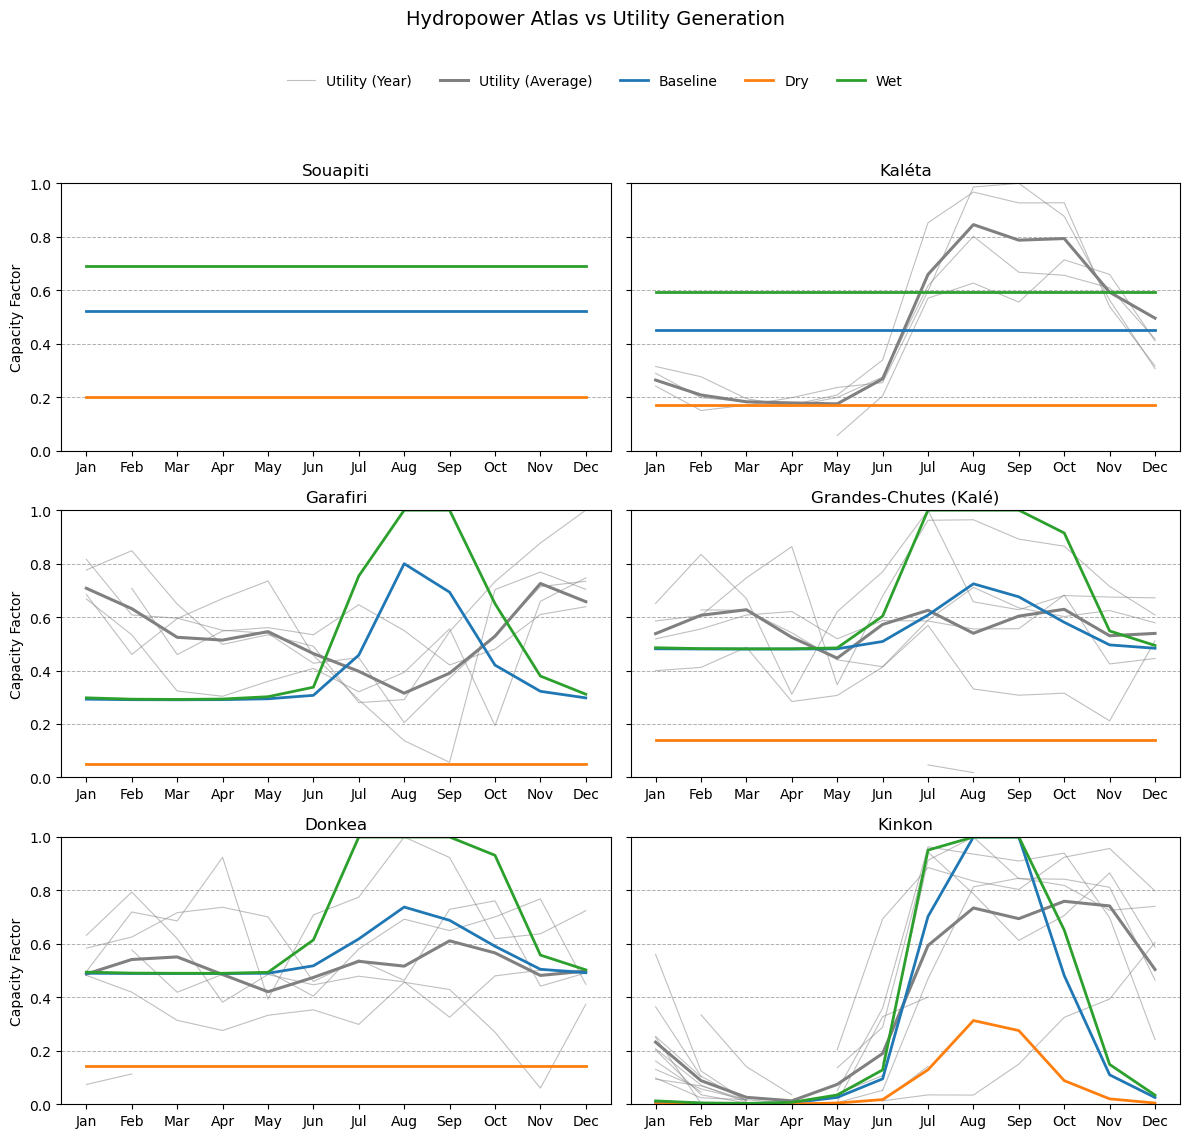

In [62]:

def plot_power_plant_scenarios(hpp_utility: pd.DataFrame,
                                data_atlas: pd.DataFrame,
                                filepath: Optional[str] = None):
    """
    Generate 2-column subplots for each power plant showing monthly values across years
    (from hpp_utility) and climate scenarios (from data_atlas), with shared axes, one legend,
    and an overall title.

    Parameters:
    -----------
    hpp_utility : pd.DataFrame
        MultiIndex DataFrame with index (year, month) named ['scenario', 'month'],
        and columns as power plant names. Represents utility inflow data (may have missing months).

    data_atlas : pd.DataFrame
        MultiIndex DataFrame with index (scenario, month) named ['scenario', 'month'],
        and columns as power plant names. Must include 'baseline', 'dry', 'wet'.

    filepath : str, optional
        If provided, saves the figure to the given path. Otherwise, displays it.

    Output:
    -------
    Displays or saves a multi-subplot figure:
        - Thin grey lines: yearly utility data
        - Thick grey line: average utility across years
        - Colored lines: baseline (blue), dry (orange), wet (green) from data_atlas
    """

    plants = hpp_utility.columns
    n_plants = len(plants)
    n_cols = 2
    n_rows = math.ceil(n_plants / n_cols)
    months = list(range(1, 13))
    month_labels = [calendar.month_abbr[m] for m in months]

    # Scenario colors
    scenario_colors = {
        'baseline': 'tab:blue',
        'dry': 'tab:orange',
        'wet': 'tab:green'
    }

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3.5 * n_rows), sharey=True)
    axes = axes.flatten()

    for i, plant in enumerate(plants):
        ax = axes[i]

        # Plot individual years
        for year in hpp_utility.index.get_level_values(0).unique():
            try:
                data = hpp_utility.loc[year][plant]
                data = data.reindex(months)
                ax.plot(months, data, color='grey', linewidth=0.8, alpha=0.5, label='_nolegend_')
            except (KeyError, ValueError):
                continue

        # Plot average
        try:
            avg_data = hpp_utility[plant].groupby('month').mean().reindex(months)
            ax.plot(months, avg_data, color='grey', linewidth=2.2, label='Utility (Average)')
        except Exception:
            pass

        # Plot atlas scenarios
        for scenario, color in scenario_colors.items():
            try:
                scenario_data = data_atlas.loc[scenario][plant].reindex(months)
                ax.plot(months, scenario_data, label=scenario.capitalize(), color=color, linewidth=2)
            except KeyError:
                continue

        ax.set_title(plant)
        ax.set_xticks(months)
        ax.set_xticklabels(month_labels)
        ax.set_ylim(0, 1)
        ax.yaxis.grid(True, linestyle='--', linewidth=0.7)
        ax.xaxis.grid(False)

        if i % n_cols == 0:
            ax.set_ylabel("Capacity Factor")
        if i >= n_plants - n_cols:
            ax.set_xlabel(None)

    # Remove unused axes
    for j in range(n_plants, len(axes)):
        fig.delaxes(axes[j])

    # Shared legend
    handles = [
        plt.Line2D([], [], color='grey', linewidth=0.8, alpha=0.5, label='Utility (Year)'),
        plt.Line2D([], [], color='grey', linewidth=2.2, label='Utility (Average)'),
        plt.Line2D([], [], color='tab:blue', linewidth=2, label='Baseline'),
        plt.Line2D([], [], color='tab:orange', linewidth=2, label='Dry'),
        plt.Line2D([], [], color='tab:green', linewidth=2, label='Wet')
    ]
    fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.03),
               frameon=False)

    fig.suptitle("Hydropower Atlas vs Utility Generation", fontsize=14, y=1.08)
    plt.tight_layout(rect=[0, 0, 1, 0.98])

    if filepath:
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

plot_power_plant_scenarios(hpp_utility, data_atlas)
plot_power_plant_scenarios(hpp_utility, data_atlas, filepath='output/hydro_atlas_vs_utility.png')